# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import bert

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
bs=64
bptt=512

In [4]:
# PATH=Path('data/wikitext-2-raw')
# PATH = Path('../midi_generator/data/composers/notewise/piano_solo/note_range62/sample_freq12')
PATH = Path('data/composers/notewise/piano_solo/note_range62/sample_freq12')
# data = TextLMDataBunch.load(PATH, cache_name='tmp_nocap', bs=bs, bptt=bptt)

In [5]:
def __maskgetitem__(self, k:int):
    if self.item is not None: return self.dataset[0]
    if not hasattr(self, 'idxs'): self.on_epoch_begin()
    #The dataloader will send (batch_index) * bs + sample_index, converting to where to read in the stream 
    read_idx = (k//self.bs) * self.bptt
    i = read_idx  + (k % self.bs) * self.n 
    seq_len = min(self.bptt, self.n-read_idx-1)
    #Getting the indexes of the texts that start and finish the portion i---i+seq_len in the stream 
    start,end = np.argmax(self.text_idx >= i)-1,np.argmin(self.text_idx <= i+seq_len+1)
    start = max(0,start)
    if end == 0: end = len(self.idxs) # (AS) sometimes end is 0
    #Grabbing the texts we need in the dataset
    if self.backwards: concat = np.concatenate([self.dataset.x.items[j][::-1] for j in self.idxs[start:end]])
    else: concat = np.concatenate([self.dataset.x.items[j] for j in self.idxs[start:end]])
    #Returning the right portion.
    start_idx = i-self.text_idx[start]
    return mask_input_np(concat[start_idx:start_idx+seq_len])

In [6]:
path = PATH
# cache_name='tmp_nocap'

In [7]:
LanguageModelPreLoader.__getitem__ = __maskgetitem__

In [8]:
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

You can deactivate this warning by passing `no_check=True`.


/home/ubuntu/fastai/fastai/basic_data.py:215: UserWarning: There seems to be something wrong with your dataset, can't access self.train_ds[i] for all i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
  warn(f"There seems to be something wrong with your dataset, can't access self.train_ds[i] for all i in {idx}")


In [9]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

158

In [10]:
MASK = 'xxfld'
MASK_IDX = vocab.stoi[MASK]
spec_tok_len = len(defaults.text_spec_tok)
vocab_size = len(vocab.stoi)
def mask_input(x):
    y = x.clone()
    rand = torch.rand(x.shape)
    y[rand > .15] = -1
    x[rand <= (.15*.8)] = MASK_IDX # 80% = mask
    wrong_word = (rand > (.15*.8)) & (rand <= .15*.9) # 10% = wrong word
    x[wrong_word] = torch.randint(spec_tok_len, vocab_size, [wrong_word.sum().item()])
    return x,y

def mask_input_np(x, mask_last=True):
    # always mask last one to train model to predict next word (for language modeling)
    x = x.copy()
    y = x.copy()
    rand = np.random.rand(*x.shape)
    pct = .2
    if mask_last:
        rand[-1] *= pct
    y[rand > pct] = -1
    x[rand <= (pct*.8)] = MASK_IDX # 80% = mask
    wrong_word = (rand > (pct*.8)) & (rand <= pct*.9) # 10% = wrong word
    x[wrong_word] = np.random.randint(spec_tok_len, vocab_size, [wrong_word.sum()])
    return x,y

In [11]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2, 124, 124, 124, ...,   9, 105,   9, 157]))

In [12]:
data.show_batch()

idx,text
0,xxbos xxfld p16 wait2 xxfld wait4 p23 p28 p30 p32 xxfld p25 endp25 wait3 p27 p31 p59 p35 wait5 endp28 xxfld endp32 xxfld p11 p23 xxfld endp11 endp23 wait3 endp27 endp31 endp33 endp35 wait1 p16 xxfld endp16 p28 xxfld xxfld p30 p32 xxfld p25 endp25 wait3 p27 p31 p33 p35 wait5 endp28 endp30 endp32 wait1 p11 p23 xxfld endp11 endp23 wait3 xxfld xxfld endp33 xxfld xxfld p16 wait2 endp16 wait4
1,wait3 endp17 endp48 wait3 p21 p39 xxfld endp21 wait1 xxfld xxfld p39 wait3 endp37 endp39 wait2 p36 wait3 endp10 endp36 xxfld xxfld p34 p37 wait3 p15 endp18 endp34 p36 endp37 p39 wait3 endp36 endp39 xxfld p34 p37 wait2 xxfld wait1 endp34 xxfld wait1 p17 p33 p36 wait3 endp17 endp33 endp36 wait2 p10 p34 wait6 p46 wait2 endp34 wait1 endp46 wait2 p42 wait3 xxfld wait1 p41 wait6 p46 wait1 endp41 wait2
2,wait1 p23 p26 p30 p33 p37 p44 xxfld p49 p52 wait3 endp26 endp30 endp33 xxfld endp44 xxfld endp49 endp52 wait3 endp37 wait3 endp23 wait1 p20 endp22 xxfld p31 p34 p37 p40 p43 p46 p42 wait2 endp28 xxfld wait3 endp31 endp40 xxfld endp34 endp43 endp46 xxfld wait5 p17 p27 p31 xxfld p38 p43 p47 wait7 endp31 xxfld endp43 wait1 endp17 endp38 wait4 p17 p27 p31 p33 p34 p38 p43 wait2 endp33
3,xxfld xxfld p22 wait6 p26 p34 p44 wait5 endp26 xxfld xxfld wait2 endp34 endp44 xxfld endp22 endp29 wait1 p15 xxfld xxfld p34 xxfld xxfld endp22 wait1 p27 wait2 endp34 endp43 wait3 endp15 xxfld wait1 p31 p51 wait5 endp31 wait1 p34 wait5 endp34 wait1 p39 wait5 endp51 wait1 p8 xxfld wait5 xxfld wait1 p20 p47 endp1 endp20 endp47 wait1 p27 p48 wait5 endp8 endp27 endp39 endp48 wait1 p26 p41 p46 wait5
4,endp39 wait1 p33 p35 p44 wait2 endp44 xxfld p39 endp35 p42 wait2 endp42 wait1 p33 p35 p44 wait2 endp44 wait1 endp33 endp35 p42 xxfld endp42 wait1 p32 p35 wait3 endp32 endp35 p40 wait2 endp40 wait1 p32 p35 p39 wait2 endp39 xxfld endp32 endp35 p40 wait2 endp40 wait1 p32 p35 p45 wait2 endp45 wait1 endp32 endp35 p44 wait2 endp44 wait1 p32 p35 p45 wait2 endp45 wait1 endp32 xxfld p44 wait2 endp44


## Sanity - make sure outputs match

In [13]:
# learn = language_model_learner(data, drop_mult=1, clip=.5, bptt=250)

# ob = data.one_batch()

# out = learn.model(ob[0].cuda())

# out[0].shape

# len(out[1])

### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [14]:
# config = gpt.OpenAIGPTConfig(vocab_size)
config = bert.BertConfig(vocab_size)

In [15]:
config.num_hidden_layers = 6
config.num_attention_heads = 8
config.hidden_size = 512
config.intermediate_size = config.hidden_size*4

In [16]:
config

{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "max_position_embeddings": 512,
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "type_vocab_size": 2,
  "vocab_size": 158
}

In [17]:
# model = bert.BertForPreTraining(config).cuda()
model = bert.BertForMaskedLM(config).cuda()
# model = gpt.OpenAIGPTLMHeadModel(config).cuda()
model.reset = lambda: None

In [22]:
# model

In [23]:
# ob = data.one_batch(); ob[0].shape

# out = model(ob[0].cuda())

# len(out)

# out[1].shape

# out[0].shape

### Create Language learner

In [18]:
class GPTLoss():
    def __init__(self):#, model):
#         self.model = model
        self.loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-1)
    def __call__(self, lm_logits, lm_labels):
        loss = self.loss_fct(lm_logits.view(-1, lm_logits.size(-1)), lm_labels.view(-1))
        return loss.float()

In [19]:
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs)[targs != -1].float().mean()

In [20]:
from fastai.text.learner import DatasetType
def show_results(self, ds_type=DatasetType.Valid, rows:int=5, max_len:int=20):
    from IPython.display import display, HTML
    "Show `rows` result of predictions on `ds_type` dataset."
    ds = self.dl(ds_type).dataset
    x,y = self.data.one_batch(ds_type, detach=False, denorm=False)
    preds = self.pred_batch(batch=(x,y))
    y = y.view(*x.size())
    z = preds.view(*x.size(),-1).argmax(dim=2)
    
#     x[y != -1] = y[y != -1] # put in real values
    x[y != -1] = MASK_IDX # put in mask values
    xs = []
    ys = []
    zs = []
    for i in range(rows):
        xs.append(ds.x.reconstruct(grab_idx(x, i)))
        y_idxs = grab_idx(y, i)
        z_idxs = grab_idx(z, i)
        ys.append(ds.x.reconstruct(y_idxs[y_idxs != -1]))
        zs.append(ds.x.reconstruct(z_idxs[y_idxs != -1]))
        
#     xs = [ds.x.reconstruct(grab_idx(x, i)) for i in range(rows)]
#     ys = [ds.x.reconstruct(grab_idx(y, i)) for i in range(rows)]
#     zs = [ds.x.reconstruct(grab_idx(z, i)) for i in range(rows)]

    items = [['text', 'target', 'pred']]
    for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
        txt_x = ' '.join(x.text.split(' ')[:max_len])
        txt_y = ' '.join(y.text.split(' ')[:max_len])
        txt_z = ' '.join(z.text.split(' ')[:max_len])
        items.append([str(txt_x), str(txt_y), str(txt_z)])
    display(HTML(text2html_table(items, ([34,33,33]))))

In [28]:
def lmpredict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    for _ in progress_bar(range(n_words), leave=False):
        xb, yb = self.data.one_item(text)
        xb = torch.cat([xb, torch.full((1,1), fill_value=MASK_IDX, dtype=xb.dtype, device=xb.device)], dim=1)
        res = self.pred_batch(batch=(xb[:, -400:],yb))[0][-1]
#         res = self.pred_batch(batch=(xb,yb))[0,-1]
        res = F.softmax(res)
        if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: res[res < min_p] = 0.
        if temperature != 1.: res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()
        text += f' {self.data.vocab.itos[idx]}'
    return text

In [29]:
LanguageLearner.predict = lmpredict

In [23]:
LanguageLearner.show_results = show_results

In [24]:
# learn = LanguageLearner(data, model, bptt)
learn = LanguageLearner(data, model, bptt, loss_func=GPTLoss(), metrics=[accuracy])

In [25]:
learn.callbacks = []

In [26]:
learn.metrics = [accuracy]

In [27]:
# learn = learn.to_fp16(512)
learn = learn.to_fp16(16384.0/32)

In [64]:
learn.show_results(max_len=50)

text,target,pred
xxfld p28 p44 p47 wait3 p52 wait4 endp47 wait1 endp28 endp44 endp52 wait4 p23 xxfld wait2 endp52 wait1 p51 wait2 endp51 wait1 xxfld wait2 endp23 endp49 wait1 p47 wait2 xxfld wait1 xxfld p52 wait5 endp28 endp52 wait1 xxfld p47 wait5 endp23 endp47 wait1 p20 p44 xxfld endp20 endp44 xxfld xxfld,xxbos p52 p49 endp47 p28 p23 wait5 wait1 p16 p49 p28 endp49 wait4 endp28 endp44 endp52 endp35 wait5 endp32 p28 wait1 p23 p27 wait2 wait1 p28 wait1 wait5 endp27 endp54 endp23 p27 wait1 wait2 wait1 endp56 endp28 p54 p23 p51 endp23 p11 p23 endp47 p23 endp11 wait4 wait1 wait4 wait2,wait4 p52 p49 endp47 p28 p23 wait5 wait1 p16 p49 p28 endp49 wait4 endp28 endp44 endp52 endp35 wait5 endp32 p28 wait1 p23 p27 wait2 wait1 p28 wait1 wait5 endp27 endp54 endp23 p27 wait1 wait2 wait1 endp56 endp28 p54 p23 p51 endp23 p11 p23 endp47 p23 endp11 wait4 wait1 wait4 wait2
wait3 endp41 p42 wait3 endp42 xxfld p44 wait3 endp44 p45 wait3 xxfld xxfld wait5 endp34 endp46 wait1 p27 p30 wait3 p42 wait3 endp42 wait1 endp27 endp30 wait2 p29 p32 p41 wait3 p39 endp41 xxfld p30 xxfld endp39 xxfld endp29 endp32 wait2 endp37 wait3 xxfld xxfld endp30 wait2 xxfld xxfld endp36,wait3 endp45 p46 wait3 p37 wait1 p36 wait1 p29 p32 wait2 endp43 p44 p44 wait3 endp44 wait1 wait3 endp30 p39 endp39 endp29 endp38 p39 endp41 wait1 p42 endp42 p46 endp34 p27 endp29 endp36 wait3 p39 wait3 endp41 wait3 wait3 endp42 endp29 wait1 endp44 p25 endp41 p39 wait1 endp17 endp25 p37,wait3 endp45 p46 wait3 p37 wait1 p36 wait1 p29 p32 wait1 endp43 p44 p44 wait2 endp44 wait1 wait3 endp30 p39 endp39 endp29 endp38 p39 endp41 wait1 p42 endp42 p46 p46 p27 endp29 endp36 wait3 p39 wait3 endp41 wait3 wait3 endp42 endp29 wait1 endp44 p25 endp41 p39 wait1 endp17 endp25 p37
endp27 wait1 endp30 wait1 p31 wait2 endp31 wait1 p25 wait1 p34 xxfld endp8 endp20 endp25 xxfld xxfld xxfld endp34 p37 wait2 p28 endp37 wait1 p32 wait1 endp28 wait1 endp32 wait1 p33 wait2 endp33 wait1 p27 wait1 p39 wait1 xxfld endp22 endp27 wait1 p12 xxfld endp39 p42 wait2 p30 endp42 wait1,wait1 wait1 p10 p22 endp10 p24 p32 wait1 endp30 wait1 wait1 wait1 wait1 endp40 p34 p41 p14 p35 p38 endp32 wait1 wait2 p35 p37 wait1 endp39 p43 wait1 endp46 endp27 wait1 p34 wait1 wait1 p27 endp43 wait2 wait1 endp39 wait2 endp47 wait1 p43 wait2 endp23 p22 endp49 p45 endp22 endp39,wait1 wait1 p10 p22 endp10 p24 p32 wait1 endp30 wait1 wait1 wait1 wait1 endp40 p34 p41 p14 p35 p38 endp32 wait1 wait2 p35 p37 wait1 endp39 p43 wait1 endp46 endp27 wait1 p34 wait1 wait1 p27 endp43 wait2 wait1 endp39 wait2 endp47 wait1 p43 wait2 endp23 p22 endp49 p45 endp22 endp39
wait1 xxfld xxfld wait1 endp27 endp33 wait1 endp28 xxfld p41 endp42 wait3 endp29 endp41 xxfld p10 p22 p49 wait2 xxfld wait1 xxfld endp22 p37 wait1 p48 wait1 endp37 wait1 p30 p46 endp48 xxfld endp30 endp46 wait3 p42 p46 wait2 xxfld xxfld xxfld p30 xxfld xxfld xxfld p44 xxfld endp30 wait1,p28 p42 p29 wait3 endp49 endp10 wait3 endp42 endp46 wait1 p34 wait1 p32 wait1 p49 wait1 p48 wait3 endp46 endp46 wait1 p34 endp30 wait1 endp32 endp42 p22 p49 wait1 endp22 p48 endp37 wait1 wait3 wait2 p30 wait1 endp42 p42 wait1 p41 endp29 p30 wait3 endp39 wait1 p27 p37 endp36 wait2,p28 p42 p29 wait3 endp49 endp10 wait3 endp42 endp46 wait1 p34 wait1 p32 wait1 p49 wait1 p48 wait3 endp46 endp46 wait1 p34 endp30 wait1 endp32 endp42 p22 p49 wait1 endp22 p48 endp37 wait1 wait3 wait2 p30 wait1 endp42 p42 wait1 p41 endp29 p30 wait3 endp39 wait1 p27 p37 endp36 wait2
wait1 p7 p31 p36 wait3 xxfld endp36 wait3 p34 p38 wait3 endp34 endp38 wait6 p39 wait2 endp39 wait1 p36 p43 wait3 xxfld endp43 wait3 p34 xxfld wait3 endp34 endp38 wait6 p31 wait2 endp31 wait1 p7 p26 xxfld wait3 endp26 endp34 wait2 endp2 endp7 xxfld p0 p33 xxfld xxfld wait6 p33,endp31 endp36 p38 p34 wait1 wait3 endp33 endp36 endp30 p2 p7 wait3 wait6 wait3 endp17 p22 wait3 wait2 wait1 wait1 endp0 p14 p3 wait6 endp15 p10 p24 wait6 wait3 endp34 endp19 endp3 wait1 p21 wait3 endp12 endp29 endp5 endp17 p22 p10 p14 wait3 wait2 wait1 endp34 wait1 wait1 p26 endp12,endp31 en

## LR Finder

In [ ]:
learn.lr_find(num_it=500)

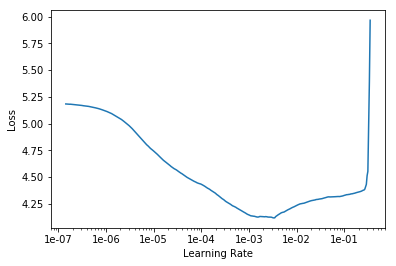

In [32]:
learn.recorder.plot()

## Must remeber that BERT is bidirectional, so we must modifythe architechture so it won't cheat

In [33]:
learn.fit_one_cycle(1, 1e-4, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,3.141718,3.007392,0.225771


In [46]:
learn.show_results()

text,target,pred
xxbos p28 p44 p47 wait3 p52 wait4 xxfld wait1 xxfld endp44 endp52 wait4 p23 p52 wait2 endp52 xxfld xxfld wait2,endp47 endp28 wait1 p51 p49 endp49 p47 p47 endp23 wait1 wait1 wait5 p45 p28 wait4 p52 wait4 wait5 endp44 p27,p47 endp28 wait1 p51 p49 endp49 p47 p47 endp23 wait1 wait1 wait5 p45 p28 wait4 p52 wait4 wait5 endp44 p27
wait3 endp41 p42 wait3 endp42 wait3 p44 wait3 endp44 xxfld wait3 endp45 xxfld wait5 endp34 endp46 xxfld p27 p30 xxfld,p45 p46 wait1 wait3 wait1 wait2 p36 p32 wait2 endp41 p44 wait2 p29 endp25 endp44 p42 endp29 p39 endp39 p41,p45 p46 wait1 wait4 wait1 wait2 p36 p32 wait2 endp41 p44 wait1 p29 endp25 endp44 p42 endp29 p39 endp39 p41
endp27 wait1 endp30 wait1 p31 wait2 endp31 wait1 p25 wait1 p34 wait1 endp8 xxfld xxfld wait1 p10 p22 endp34 p37,endp20 endp25 wait1 wait2 wait1 wait2 p13 p25 endp40 endp32 wait1 wait1 wait1 endp29 p44 wait2 p37 wait1 endp37 p44,endp20 endp25 wait1 wait2 wait1 wait2 p13 p25 endp40 endp32 wait1 wait1 wait1 endp29 p44 wait2 p34 wait1 endp37 p44
xxfld xxfld p42 wait1 endp27 endp33 wait1 endp28 p29 p41 endp42 wait3 endp29 endp41 wait3 p10 p22 p49 wait2 endp49,wait1 p28 p37 endp48 wait3 p46 wait2 endp46 wait1 endp44 endp42 p22 endp49 wait1 p37 wait3 endp46 p46 wait1 p34,wait1 p28 p37 endp48 wait3 p46 wait2 endp46 wait1 endp44 endp42 p22 endp49 wait1 p37 wait3 endp46 p46 wait1 p34
wait1 p7 p31 xxfld wait3 xxfld xxfld wait3 p34 p38 wait3 endp34 endp38 wait6 p39 xxfld endp39 wait1 p36 p43,p36 endp31 endp36 wait2 p31 p34 wait2 endp30 p2 p24 wait2 p19 p17 endp22 p34 wait1 p26 p19 wait2 wait2,p39 endp31 endp43 wait2 p31 p34 wait2 endp30 p2 endp30 wait2 p19 p17 endp22 p34 wait1 p26 p19 wait2 wait2


In [35]:
learn.save('bert_epoch_1')

In [ ]:
learn.load('bert_epoch_1')

In [28]:
learn.fit_one_cycle(2, 1e-4, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,2.380979,2.257844,0.400657
2,1.253272,1.079871,0.698453


In [29]:
learn.save('bert_epoch_2')

In [29]:
learn = learn.load('bert_epoch_2')

In [30]:
learn.fit_one_cycle(10, 1e-4, div_factor=5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.134367,0.921649,0.740523
2,0.919515,0.741058,0.790631
3,0.727951,0.592146,0.831317
4,0.607121,0.496664,0.857642
5,0.573800,0.440116,0.873767
6,0.493392,0.388303,0.887584
7,0.453076,0.362355,0.895146
8,0.388987,0.347326,0.899181
9,0.424208,0.336593,0.901880
10,0.428322,0.335391,0.902473


In [31]:
learn.save('bert_epoch_10_overnight')

In [32]:
learn.show_results()

text,target,pred
xxbos xxfld p44 p47 xxfld p52 wait4 xxfld wait1 endp28 endp44 endp52 wait4 p23 p52 xxfld endp52 wait1 p51 wait2,p28 wait3 endp47 wait4 wait2,wait1 p28 p44 p47 wait3 p52 wait4 endp47 wait1 endp28 endp44 endp52 wait4 p23 p52 wait2 endp52 wait1 p51 wait2
wait3 endp41 p42 wait3 xxfld wait3 p44 wait3 endp44 p45 wait3 xxfld p46 wait5 endp34 xxfld wait1 p27 p30 wait3,endp42 endp45 endp46,wait3 endp41 p42 wait3 endp42 wait3 p44 wait3 endp44 p45 wait3 endp45 p46 wait5 endp34 endp46 wait1 p27 p30 wait3
endp27 wait1 endp30 wait1 p31 wait2 endp31 wait1 p25 xxfld xxfld wait1 endp8 endp20 endp25 wait1 p10 p22 endp51 p37,wait1 p34 endp34,endp27 wait1 endp30 wait1 p31 wait2 endp31 wait1 p25 wait1 p32 wait1 endp8 endp20 endp25 wait1 p10 p22 endp32 p37
wait1 p28 p42 wait1 endp27 endp33 wait1 endp28 p29 p41 endp42 xxfld endp29 endp41 wait3 p10 p22 p49 wait2 endp49,wait3 wait3,wait1 p28 p42 wait1 endp27 endp33 wait1 endp28 p29 p41 endp42 wait3 endp29 endp41 wait3 p10 p22 p49 wait2 endp49
wait1 p7 p31 p36 wait3 endp31 xxfld wait3 p34 p38 wait3 endp34 endp38 wait6 p39 wait2 xxfld wait1 p36 p43,endp36 endp39,wait1 p7 p31 p36 wait3 endp31 endp36 wait3 p34 p38 wait3 endp34 endp38 wait6 p39 wait2 endp39 wait1 p36 p43


In [39]:
learn.load('bert_epoch_10_overnight')
learn.unfreeze()

In [86]:
learn.fit_one_cycle(5, 5e-5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,0.477270,0.353203,0.897735
2,0.436281,0.345406,0.900068


KeyboardInterrupt: 

In [ ]:
learn.save('bert_epoch_2_finetune_last')

### Predictions

In [58]:
learn = learn.load('bert_epoch_2_finetune_last')

In [59]:
learn.show_results()

text,target,pred
xxfld p28 p44 p47 wait3 xxfld xxfld endp47 xxfld endp28 endp44 endp52 wait4 xxfld p52 wait2 xxfld wait1 p51 wait2,xxbos p52 wait4 wait1 p23 endp52 p28 p52 wait1 endp23 wait5 endp20 endp40 p28 wait2 endp45 p52 wait2 wait4 p44,wait4 p52 wait4 wait1 p23 endp52 p28 p52 wait1 endp23 wait5 endp20 endp40 p28 wait2 endp45 p52 wait2 wait4 p44
wait3 endp41 p42 wait3 endp42 wait3 p44 wait3 endp44 p45 wait3 endp45 p46 xxfld endp34 endp46 wait1 p27 p30 wait3,wait5 endp42 endp30 endp41 wait2 p29 p32 wait2 wait3 endp41 wait3 endp43 endp44 wait3 wait3 endp39 wait1 p38 wait3 p42,wait3 endp42 endp30 endp41 wait2 p29 p32 wait2 wait3 endp41 wait3 endp43 endp44 wait3 wait3 endp39 wait1 p38 wait3 p42
endp27 xxfld endp30 wait1 p31 wait2 xxfld wait1 p25 wait1 p34 wait1 endp8 endp20 xxfld wait1 p10 p22 endp34 p37,wait1 endp31 endp25 p42 wait1 endp32 wait1 wait1 p40 wait1 wait1 endp35 endp38 p32 p44 p27 p47 p37 endp37 p43,wait1 endp31 endp25 p42 wait1 endp32 wait1 wait1 p40 wait1 wait1 endp35 endp38 p32 p44 p27 p47 p37 endp37 p43
xxfld p28 p42 wait1 endp27 endp33 wait1 xxfld xxfld p41 endp42 wait3 endp29 endp41 wait3 p10 p22 p49 wait2 xxfld,wait1 endp28 p29 endp49 endp22 endp37 wait3 wait1 wait2 endp22 endp37 wait1 wait1 wait1 wait1 p42 wait3 endp42 wait3 p22,wait1 endp28 p29 endp49 endp22 endp37 wait3 wait1 wait2 endp22 endp37 wait1 wait1 wait1 wait1 p42 wait3 endp42 wait3 p22
wait1 p7 p31 p36 wait3 endp31 endp36 wait3 p34 p38 wait3 endp34 endp38 wait6 p39 xxfld endp39 wait1 xxfld p43,wait2 p36 p38 wait3 endp34 p34 wait1 wait6 p34 wait6 p31 p22 endp22 endp26 wait3 wait3 endp34 p0 wait1 p12,wait2 p36 p38 wait3 endp34 p34 wait1 wait6 p34 wait6 p31 p19 endp19 endp26 wait3 wait3 endp34 endp34 wait1 p12


In [49]:
idx = 12
folder_idx = 2 # 2 = bach
seed_len = 50

file = path.ls()[folder_idx].ls()[idx]
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len])

note_offset = 45 if 'note_range38' in str(file) else 33
sample_freq = 12 if 'sample_freq12' in str(file) else 4

note_offset, sample_freq, file

(33,
 12,
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/bach/813_5bm2.txt'))

In [50]:
pred_out = learn.predict(seed, n_words=50)

### Testing

In [51]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'p24 p36 wait5 endp36 wait1 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6 p24 p36 wait6'

In [52]:
from utils import *
import music21
from music21 import *
from IPython.display import Image, Audio

In [53]:
pred_format = pred_only.replace('xxbos ', '')

In [54]:
note_stream = arrToStreamNotewise(pred_format.split(' '), sample_freq=sample_freq/2, note_offset=45)

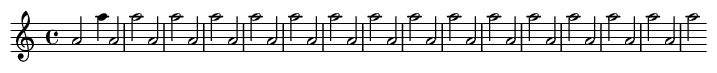

In [55]:
Image(filename=str(note_stream.write('lily.png')))

In [56]:
note_stream.show('midi')

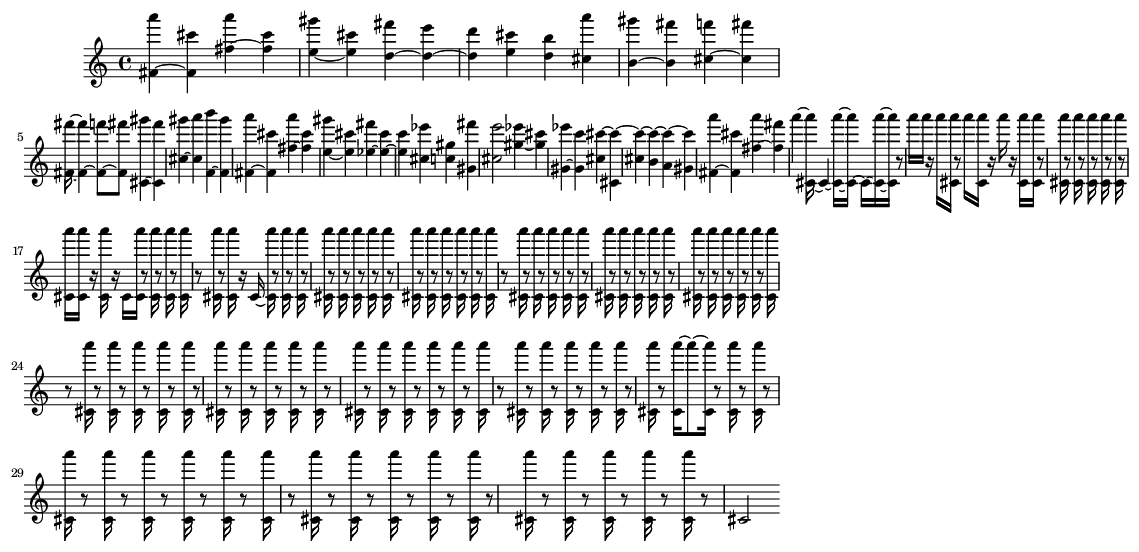

In [41]:
Image(filename=str(note_stream.chordify().write('lily.png')))

In [33]:
ob = data.one_batch(cpu=False)

out = learn.pred_batch(batch=ob)

out.shape

torch.Size([64, 512, 158])

In [34]:
z = out.view(*ob[0].size(),-1).argmax(dim=-1)

In [42]:
out.shape

torch.Size([16, 250, 33548])

In [35]:
z

tensor([[124, 124, 146,  ...,   8,  59,   9],
        [ 41,  26,   8,  ...,  66,   9,  56],
        [ 53,   9, 120,  ...,  12,  70,  15],
        ...,
        [  9,  79,  57,  ...,  61,   8,  22],
        [ 49,  36,   8,  ...,   8,  79,  63],
        [ 31,   8,  24,  ...,  43,  10,  46]])

In [33]:
learn.show_results()

text,target,pred
"xxfld = xxfld gammarus = xxbos Homarus gammarus , known as xxfld European lobster or common lobster , is a",gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae Ocean gallinae gallinae Sea gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae,the the the the the the the the the the the the the the the the the the the the
", when a No . 38 Squadron Dakota he was co - xxunk on a supply drop xxfld - landed",gallinae gallinae gallinae gallinae xxunk gallinae following gallinae gallinae . In gallinae 1951 he gallinae gallinae gallinae gallinae gallinae gallinae,the the the the the the the the the the the the the the the the the the the the
"xxfld xxunk referred to xxunk as one of his xxfld characters from xxunk . xxbos Several publications for xxfld ,",gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae . gallinae gallinae gallinae that,the the the the the the the the the the the the the the the the the the the the
"xxfld xxunk , xxfld from xxfld xxfld . The xxfld clerk is Pam xxunk . In total , the city",gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae a gallinae of gallinae gallinae gallinae gallinae gallinae gallinae gallinae after Hurricane,the the the the the the the the the the the the the the the the the the the the
"xxfld . After closing in the late 1920s due to the Great Depression , the opera house was xxfld for","gallinae 70 gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae , a gallinae foundation gallinae",the the the the the the the the the the the the the the the the the the the the
